In [83]:
import time
import numpy as np
from copy import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import datasets
from sklearn.metrics import accuracy_score

In [84]:
def hinge_loss(x, y, w, b, rho):
    # Terms
    reg = rho*(np.linalg.norm(w)**2)
    cost = 1 - np.multiply(y, np.sum(w.T*x, axis = 1) - b)
    
    return np.mean(np.maximum(0, cost)**2) + reg

def dhinge_loss(x, y, w, b, rho):
    # Terms
    n = x.shape[0]
    cost = 1 - np.multiply(y, np.sum(w.T*x, axis = 1) - b)
    dreg = 2.*rho*w.T
    
    # Calculation
    dcost_w = np.sum(-2.*np.multiply(np.multiply(y[:, np.newaxis], x), np.maximum(0, cost)[:, np.newaxis]), axis = 0) + dreg
    dcost_b = np.sum(2.*np.multiply(y, np.maximum(0, cost)))
    
    return (1./n)*dcost_w.T, (1./n)*dcost_b

In [85]:
class SGD(object):
    def __init__(self, rho, cost, dcost):
        # Given parameters
        self.rho = rho
        self.cost_func = cost
        self.dcost = dcost
        
        # Internal parameters
        self.w = None
        self.b = None
        self.loss = []

    def __shuffle(self, x, y):
        n = x.shape[0]
        
        # Create a permutation of the n points
        permutation = np.random.permutation(n)
        
        return x[permutation], y[permutation]
    
    def __init_params(self, x):
        n = x.shape[1]
        w, b = np.random.rand(n, 1), np.random.rand()
        return w, b
    
    def __update_weigths(self, x, y, lr):
        # Create a copy of the weights
        w, b = copy(self.w), copy(self.b)
        
        # Derivative of w and b
        linear = np.sum(self.w.T*x, axis = 1) - self.b
        dw, db = self.dcost(x, y, w, b, self.rho)
        
        # Update the weigths
        w -= lr*dw
        b -= lr*db
        
        return w, b
    
    def fit(self, x, y, epochs = 100, batch_size = 32, lr = 0.005):
        n = x.shape[0]
        
        # Check dimension
        if n != y.shape[0]:
            raise ValueError("X and Y have a different number of points")
        
        self.w, self.b = self.__init_params(x)
        
        # Iterate over all epochs
        print("-- running {} epochs\n".format(epochs))
        for epoch in tqdm(range(epochs)):
            x, y = self.__shuffle(x, y)
    
            # Mini-batch
            for i in range(0, n, batch_size):
                x_batch = x[i:(i+batch_size)]
                y_batch = y[i:(i+batch_size)]
                
                # update the model
                lr = 2./(2.*self.rho + (np.sum(x_batch**2)/batch_size))/100
                self.w, self.b = self.__update_weigths(x_batch, y_batch, lr)
   
                # Compute the loss
                self.loss.append(self.cost_func(x_batch, y_batch, self.w, self.b, self.rho))

        print("-- Training accuracy = {0:.2f}%".format(self.__train_acc(x, y)*100))
    
    def __train_acc(self, x, y):
        y_pred = np.sum(self.w.T*x, axis = 1) - self.b
        y_pred[y_pred<0] = -1 
        y_pred[y_pred>=0] = 1
        
        return accuracy_score(y_pred,y)
    
    def plot_loss(self):
        plt.plot(self.loss)
        plt.show()

In [86]:
class SVRG(object):
    def __init__(self, rho, cost, dcost):
        # Given parameters
        self.rho = rho
        self.cost_func = cost
        self.dcost = dcost
        
        # Internal parameters
        self.w, self.b = None, None
        self.w_sr, self.b_sr = None, None
        self.loss = []

    def __shuffle(self, x, y):
        n = x.shape[0]
        
        # Create a permutation of the n points
        permutation = np.random.permutation(n)
        
        return x[permutation], y[permutation]
    
    def __init_params(self, x):
        n = x.shape[1]
        w, b = np.random.rand(n, 1), np.random.rand()
        
        # Init the history
        self.w_sr, self.b_sr = copy(w), copy(b)
        
        return w, b
    
    def __update_weigths(self, x, y, lr):
        # Create a copy of the weights
        w, b = copy(self.w), copy(self.b)
        
        # Derivative of w and b
        dw, db = self.dcost(x, y, w, b, self.rho)
        
        # Update the weigths
        w -= lr*dw
        b -= lr*db
        
        return w, b
    
    def __update_full_grads(self, x, y, x_batch, y_batch, lr):
        w, b = copy(self.w), copy(self.b)
        w_sr, b_sr = copy(self.w_sr), copy(self.b_sr)
        
        # Derivative of w and b, w_sr, b_sr and full grad
        dw_sr, db_sr = self.dcost(x_batch, y_batch, w_sr, b_sr, self.rho)
        dw, db = self.dcost(x_batch, y_batch, w, b, self.rho)
        dw_f,db_f = self.dcost(x, y, w_sr, b_sr, self.rho)
        
        # Update the weigths
        w -= lr*(dw - dw_sr + dw_f)
        b -= lr*(db - db_sr + db_f)
        
        return w, b
    
    def fit(self, x, y, epochs = 100, batch_size = 32, lr = 0.005, r = 10):
        n = x.shape[0]
        
        # Check dimension
        if n != y.shape[0]:
            raise ValueError("X and Y have a different number of points")
        
        self.w, self.b = self.__init_params(x)
        
        # Iterate over all epochs
        print("-- running {} epochs\n".format(epochs))
        for epoch in tqdm(range(epochs)):
            x, y = self.__shuffle(x, y)
    
            # Mini-batch
            for i in range(0, n, batch_size):
                update = (i/(batch_size-1)) % r == 0
                
                x_batch = x[i:(i+batch_size)]
                y_batch = y[i:(i+batch_size)]
                                
                # update the model
                lr = 2./(2.*self.rho + (np.sum(x_batch**2)/batch_size))/100
                
                if not update:
                    self.w, self.b = self.__update_weigths(x_batch, y_batch, lr)
                else:
                    self.w, self.b = self.__update_full_grads(x, y, x_batch, y_batch, lr)
   
                # Compute the loss
                self.loss.append(self.cost_func(x_batch, y_batch, self.w, self.b, self.rho))
        
        print("-- Training accuracy = {0:.2f}%".format(self.__train_acc(x, y)*100))
    
    def __train_acc(self, x, y):
        y_pred = np.sum(self.w.T*x, axis = 1) - self.b
        y_pred[y_pred<0] = -1 
        y_pred[y_pred>=0] = 1
        
        return accuracy_score(y_pred,y)
    
    def plot_loss(self):
        plt.plot(self.loss)
        plt.show()

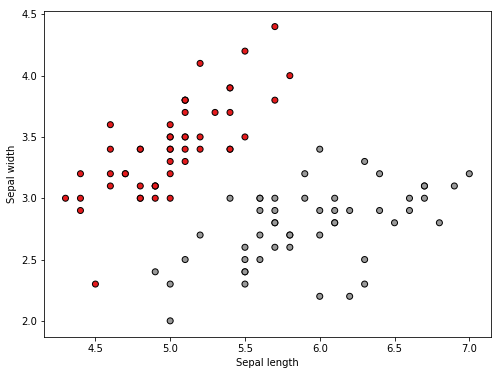

In [87]:
# Load iris (only two classes and 2 features)
iris = datasets.load_iris()
X = iris.data[:100, :2]
y = iris.target[:100]

# Convert to two class problem
y[y == 0] = -1
y[y > 0] = 1

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

-- running 50 epochs



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 269.84it/s]


-- Training accuracy = 100.00%


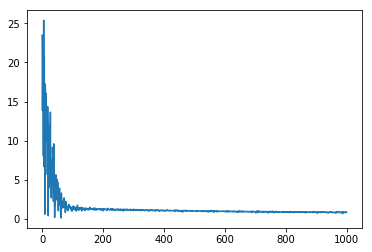

In [88]:
lr = SGD(rho = 1, cost = hinge_loss, dcost = dhinge_loss)
lr.fit(X, y, epochs=50, batch_size=5)
lr.plot_loss()

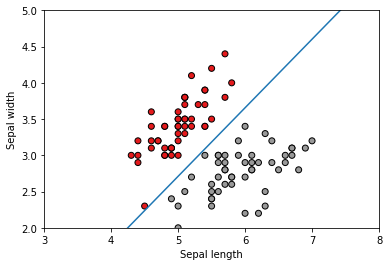

In [89]:
# Plot the training points
xpts = np.arange(-100, 100, 0.01)
ypts = (lr.b/lr.w[1][0]) - (lr.w[0][0]/lr.w[1][0])*xpts 

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
plt.plot(xpts, ypts)

plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(3, 8)
plt.ylim(2, 5)
plt.show()

-- running 50 epochs



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 217.97it/s]


-- Training accuracy = 99.00%


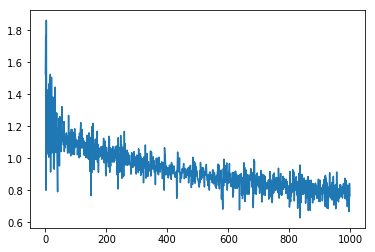

In [90]:
svgd = SVRG(rho = 1, cost = hinge_loss, dcost = dhinge_loss)
svgd.fit(X, y, epochs=50, batch_size = 5, r = 5)
svgd.plot_loss()

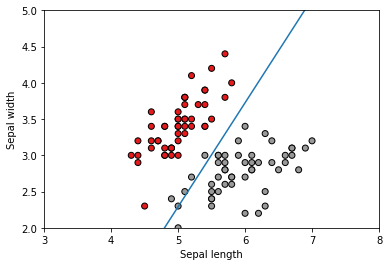

In [11]:
# Plot the training points
xpts = np.arange(-100, 100, 0.01)
ypts = (svgd.b/svgd.w[1][0]) - (svgd.w[0][0]/svgd.w[1][0])*xpts 

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
plt.plot(xpts, ypts)

plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(3, 8)
plt.ylim(2, 5)
plt.show()